# UPM EC Test 


In [1]:
test_data = 'GSE41169_series_matrix.txt.gz'

In [110]:
upm_scripts = '/Users/colinfarrell/Documents/UPM_Project/EpigeneticClock_UniversalPaceMaker'

In [111]:
import sys
sys.path.append(upm_scripts)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from UPMRun import MethylationEM
from PredictAges import predict_age

In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
#! /usr/bin/env python3

import gzip


class OpenTextFile:
    """ Simple iterator to open standard text file formats
        Keyword Arguments
            text_file_path (str): Path to text file to iterate through
            separator (str): character used to split output string
            yield_indices (list, tuple): list or tuple of indices to yield if the entire line isn't needed
            yield_start (str): when str is observed lines are then yielded at the next line
            yield_end (str): when str is observed lines stop being yielded at the line
        Attributes:
            self.f (text.io): object to stream text/ byte lines
        """

    def __init__(self, text_file_path=None, separator='\t', yield_indices=None, yield_start=None, yield_end=None):
        assert isinstance(text_file_path, str)
        self.separator = separator
        self.yield_indices = yield_indices
        if yield_indices:
            assert isinstance(yield_indices, (list, tuple))
        self.yield_start = yield_start
        if self.yield_start:
            assert isinstance(yield_start, str)
        self.yield_end = yield_end
        if text_file_path.endswith(".gz"):
            self.file = gzip.open(text_file_path, 'rb')
        else:
            self.file = open(text_file_path, 'r')
        self.start_yield = True
        if self.yield_start:
            self.start_yield = False
        self.yield_stop = None

    def __iter__(self):
        # open file
        while True:
            # read line
            line = self.file.readline()
            # if line is blank break loop
            if not line or self.yield_stop:
                break
            # process line
            processed_line = self.process_line(line)
            # check if line should be yielded
            if self.check_yield(processed_line):
                yield processed_line

    def check_yield(self, line):
        # if yield identifier is None always return true
        if not self.start_yield:
            if self.yield_start in line[0]:
                # return false and on next iteration return True
                self.start_yield = True
            return False
        # if self.yield_end check for str in line and stop iteration at the line
        if self.yield_end:
            if self.yield_end in line[0]:
                self.yield_stop = True
                return False
        return True

    def process_line(self, line):
        # decode str if byte
        if isinstance(line, bytes):
            processed_line = line.decode('utf-8').replace('\n', '').split(self.separator)
        else:
            processed_line = line.replace('\n', '').split(self.separator)
        # if yield_indices return processed line
        if self.yield_indices:
            if len(processed_line) > 1:
                return [processed_line[index] for index in self.yield_indices]
        return processed_line

In [6]:
class SeriesMatrixPhenotypeExtractor:

    def __init__(self, series_matrix_path=None, sample_id=None,
                 phenotype_ids=None, stop_descriptor='!series_matrix_table_begin'):
        self.series_matrix = OpenTextFile(text_file_path=series_matrix_path, yield_end=stop_descriptor)
        self.sample_id = sample_id
        self.phenotype_ids = phenotype_ids
        self.phenotype_matrix = {}
        self.series_description = {}
        self.series_matrix_raw_metadata = {}

    def get_meta_data(self):
        self.get_matrix_meta()
        self.experiment_id = self.series_matrix_raw_metadata['!Series_geo_accession'][0].strip('"')
        self.platform_id = self.series_matrix_raw_metadata['!Series_platform_id'][0].strip('"')
        self.data_processing = self.get_descriptive_lines('!Sample_data_processing')
        self.tissue_source = self.get_descriptive_lines('!Sample_source_name_ch1')
        self.sample_extraction = self.get_descriptive_lines('!Sample_extract_protocol_ch1')
        self.sample_ids = self.get_sample_ids
        self.get_matrix_meta()
        self.parse_metadata()

    def get_descriptive_lines(self, line_id):
        return [sample.strip('"') for sample in self.series_matrix_raw_metadata[line_id]]

    @property
    def get_sample_ids(self):
        sample_ids = [sample.strip('"') for sample in self.series_matrix_raw_metadata[self.sample_id]]
        for count, sample_id in enumerate(sample_ids):
            self.phenotype_matrix[sample_id.strip('"')] = {'experiment_id': self.experiment_id,
                                                           'platform_id': self.platform_id,
                                                           'tissue_source': self.tissue_source[count],
                                                           'data_processing': self.data_processing[count],
                                                           'sample_extraction': self.sample_extraction[count]}
        return sample_ids

    def get_matrix_meta(self):
        for count, line in enumerate(self.series_matrix):
            if len(line) > 1:
                if line[0] in self.series_matrix_raw_metadata.keys():
                    self.series_matrix_raw_metadata[f'{line[0]}___{count}'] = line[1:]
                else:
                    self.series_matrix_raw_metadata[f'{line[0]}'] = line[1:]

    def parse_metadata(self):
        for key, value in self.series_matrix_raw_metadata.items():
            if key.split('___')[0] in self.phenotype_ids:
                for phenotype, sample_id in zip(value, self.sample_ids):
                    phenotype_split = phenotype.strip(' "').split(':')
                    if len(phenotype_split) > 1:
                        phenotype_label = phenotype_split[0]
                        self.phenotype_matrix[sample_id][phenotype_label] = phenotype_split[1].lstrip()

In [7]:
import numpy as np
from tqdm import tqdm 

class ExtractSeriesMethylationData:

    def __init__(self, series_matrix_files=None, vector_size=2000, verbose=True):
        assert isinstance(series_matrix_files, list)
        self.series_matrix_files = series_matrix_files
        self.vector_size = vector_size
        self.tqdm_disable = True if not verbose else False
        self.methylation_matrix = {'ID_REF':[]}

    @staticmethod
    def convert_to_numeric(value):
        try:
            value = float(value)
        except ValueError:
            return np.nan
        return value

    @property
    def extract_series(self):
        sample_count = 0
        for series_matrix in tqdm(self.series_matrix_files, disable=self.tqdm_disable):
            experiment_sample_size = 0
            for line in self.get_series_iterator(series_matrix):
                site_label = line[0].replace('"', '')
                if not experiment_sample_size:
                    experiment_sample_size = len(line[1:])
                    self.methylation_matrix['ID_REF'].extend([sample.replace('"', '') for sample in line[1:]])
                    continue
                try:
                    site_values = self.methylation_matrix[site_label]
                except KeyError:
                    site_values = np.zeros(self.vector_size)
                    site_values.fill(np.nan)
                    self.methylation_matrix[site_label] = site_values
                finally:
                    for count, sample_value in enumerate(line[1:]):
                        site_values[sample_count + count] = self.convert_to_numeric(sample_value)
            sample_count += experiment_sample_size
        return sample_count

    def process_methylation_data(self):
        methylation_sample_size = self.extract_series
        for c_site, c_values in self.methylation_matrix.items():
            self.methylation_matrix[c_site] = c_values[0:methylation_sample_size]

    def get_series_iterator(self, series_matrix_path):
        return OpenTextFile(text_file_path=series_matrix_path, yield_start='!series_matrix_table_begin', yield_end='!series_matrix_table_end') 

In [8]:
data_extraction = ExtractSeriesMethylationData(series_matrix_files=[test_data])
data_extraction.process_methylation_data()

100%|██████████| 1/1 [00:28<00:00, 28.63s/it]


In [9]:
cpg_site_order = []
cpg_samples = list(data_extraction.methylation_matrix['ID_REF'])

methylation_matrix = np.zeros((len(data_extraction.methylation_matrix)-1, len(cpg_samples)))
print(methylation_matrix.shape)

site_count = 0

for cpg_site, cpg_values in data_extraction.methylation_matrix.items():
    if cpg_site != 'ID_REF':
        cpg_site_order.append(cpg_site)
        methylation_matrix[site_count] = cpg_values
        site_count += 1

(485577, 95)


In [10]:
phenotype_data = {}
for series_matrix in [test_data]:
    matrix_parser = SeriesMatrixPhenotypeExtractor(series_matrix_path=f'{series_matrix}', sample_id='!Sample_geo_accession', phenotype_ids=['!Sample_characteristics_ch1'])
    matrix_parser.get_meta_data()
    phenotype_data.update(matrix_parser.phenotype_matrix)

In [11]:
sample_ages = [float(phenotype_data[x]['age']) for x in cpg_samples]

In [12]:
age_average = np.mean(sample_ages)
age_std = np.std(sample_ages)

In [13]:
meth_df = pd.DataFrame(data=methylation_matrix, index=cpg_site_order, columns=cpg_samples)

In [14]:
meth_df = meth_df.dropna(axis=0)

## Selection UPM Sites

In [15]:
import bisect

score_ranges =  [15 + x * 5 for x in range(10) ]
ridge_age_bins = []


for a in sample_ages:
    ridge_age_bins.append(bisect.bisect_left(score_ranges, a))

In [16]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [17]:
ridge_default_params = {'alpha':10.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True, 'max_iter':100, 'tol':0.0001, 'solver':'auto', 'random_state':None}

In [18]:
from tqdm import tqdm

## LOV Analysis

In [114]:
class TrainTestUPM:
    
    def __init__(self, training_ages=None, training_methylation=None, training_samples=None, testing_ages=None, testing_methylation=None, testing_samples=None, cpg_site_labels=None):
        self.training_ages = training_ages
        self.training_methylation = training_methylation
        self.training_samples =  training_samples
        self.testing_ages = testing_ages
        self.testing_methylation = testing_methylation
        self.testing_samples = testing_samples
        self.cpg_site_labels = cpg_site_labels
        self.PM_model = None
        self.test_ages = None
        
    def run(self):
        self.fit_model()
        self.predict_test()
        
    def fit_model(self):
        self.PM_model = MethylationEM(methylation_table=self.training_methylation,
                                      sample_list=self.training_samples,
                                      site_list=self.cpg_site_labels,
                                      times=self.training_ages,
                                      iter_limit=100,
                                      err_tolerance=0.00001)
        
    def predict_test(self):
        self.test_ages = predict_age(table=self.testing_methylation, 
                                     r_rates=self.PM_model.UPM_EC_EM_results['PM_rates'], 
                                     r_d=self.PM_model.UPM_EC_EM_results['PM_d'])

In [157]:
class SelectStableSites:
    
    def __init__(self, methylation_array=None, selection_values=None, selection_size=.6, selection_coef=0.02, selection_iter=30, selection_count=10, stratification_values=None, 
                 ridge_params={'alpha':10.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True, 'max_iter':100, 'tol':0.0001, 'solver':'auto', 'random_state':None}):
        self.ridge_params = ridge_params
        self.methylation_array = methylation_array
        self.selection_values = selection_values
        self.selection_size = selection_size
        self.selection_coef = selection_coef
        self.selection_iter = selection_iter
        self.selection_count = selection_count
        self.stratificaiton_values = stratification_values
        self.sample_indicies = [index for index in range(len(methylation_array[0]))]
        self.site_selection_count = {}
        self.selected_indicies = []
        
    def select_subset(self):
        ridge_signal, _, ridge_samples, _ = train_test_split(self.selection_values, self.sample_indicies, test_size=self.selection_size, stratify=self.stratificaiton_values)
        ridge_array = self.methylation_array[:, ridge_samples]
        return ridge_signal, ridge_array
    
    def ridge_regression(self):
        ridge = Ridge(**ridge_default_params)
        ridge_signal, ridge_array = self.select_subset()
        ridge.fit(ridge_array.T, ridge_signal)
        for count, coef in enumerate(ridge.coef_):
            if coef > self.selection_coef:
                if count in self.site_selection_count:
                    self.site_selection_count[count] += 1
                else:
                    self.site_selection_count[count] = 1
                    
    def run_ridge_iter(self):
        for _ in range(self.selection_iter):
            self.ridge_regression()
            
    def select_sites(self):
        self.run_ridge_iter()
        for index, count in self.site_selection_count.items():
            if count >= self.selection_count:
                self.selected_indicies.append(index)
        

In [158]:
class UPM_CV:
    
    def __init__(self, methylation_array=None, upm_signal=None, cv_size=1, stratification_bins=None, sample_labels=None ):
        self.methylation_array = methylation_array
        self.upm_signal = upm_signal
        self.cv_size = cv_size
        self.stratifcation_bins = stratification_bins
        if self.stratifcation_bins:
            self.get_signal_bins()
        self.sample_indicies = [x for x in range(len(methylation_array[0]))]
        self.sample_labels = sample_labels
        self.predicted_ages = {}
            
    def get_signal_bins(self):
        min_signal = min(self.upm_signal)
        max_signal = max(self.upm_signal)
        step_size = (max_signal - min_signal) / (self.stratifcation_bins - 1)
        score_ranges =  [min(self.upm_signal) + step_size * x for x in range(self.stratifcation_bins)]
        signal_bins = []
        for a in self.upm_signal:
            signal_bins.append(bisect.bisect_left(score_ranges, a))
        self.stratifcation_bins = signal_bins
        
    def cv_upm_run(self):
        steps = int(len(self.sample_indicies)/ self.cv_size)
        for x in tqdm(range(steps), 'Processing Samples'):
            start = x * self.cv_size
            end = start + self.cv_size
            # select test indicies
            test_samples = self.sample_indicies[start:end]
            test_methylation_array = self.methylation_array[:,start:end]
            test_signal = self.upm_signal[start:end] 
            # select training indicies
            training_samples = [x for x in self.sample_indicies if x not in test_samples]
            training_methylation_array = self.methylation_array[:,training_samples]
            training_signal = [self.upm_signal[x] for x in training_samples]
            training_stratifcation = None
            if self.stratifcation_bins:
                training_stratifcation = [self.stratifcation_bins[x] for x in training_samples]
            # get radomized ridge sites
            training_sites = self.select_stable_sites(training_methylation_array, training_signal, training_stratifcation)
            # subest methylation array
            test_methylation_array = test_methylation_array[training_sites,:]
            training_methylation_array = training_methylation_array[training_sites, :]
            # get upm object 
            upm = TrainTestUPM(training_ages=training_signal, training_methylation=training_methylation_array, training_samples=training_samples, 
                               testing_ages=test_signal, testing_methylation=test_methylation_array, testing_samples=test_samples)
            upm.run()
            for sample_index, sample_age in zip(test_samples, upm.test_ages['PM_times']):
                self.predicted_ages[self.sample_labels[sample_index]] = sample_age            
            
    def select_stable_sites(self, selection_array, training_signal, training_stratifcation):
        site_selection = SelectStableSites(methylation_array=selection_array, selection_values=training_signal, stratification_values=training_stratifcation)
        site_selection.select_sites()
        return site_selection.selected_indicies

In [159]:
test = UPM_CV(methylation_array=meth_df.values, upm_signal=sample_ages, stratification_bins=None, sample_labels=list(meth_df), cv_size=1)
test.cv_upm_run()









Processing Samples:   0%|          | 0/95 [00:00<?, ?it/s]







Processing Samples:   1%|          | 1/95 [00:15<24:03, 15.36s/it]







Processing Samples:   2%|▏         | 2/95 [00:29<23:15, 15.00s/it]







Processing Samples:   3%|▎         | 3/95 [00:47<24:28, 15.96s/it]







Processing Samples:   4%|▍         | 4/95 [01:10<27:28, 18.11s/it]







Processing Samples:   5%|▌         | 5/95 [01:25<25:34, 17.05s/it]







Processing Samples:   6%|▋         | 6/95 [01:40<24:12, 16.32s/it]







Processing Samples:   7%|▋         | 7/95 [01:55<23:20, 15.91s/it]







Processing Samples:   8%|▊         | 8/95 [02:11<23:18, 16.07s/it]







Processing Samples:   9%|▉         | 9/95 [02:27<22:48, 15.92s/it]







Processing Samples:  11%|█         | 10/95 [02:43<22:37, 15.97s/it]







Processing Samples:  12%|█▏        | 11/95 [02:59<22:33, 16.11s/it]







Processing Samples:  13%|█▎        | 12/95 [03:13<21:27, 15.51s/it]







Processing Samples:  14%|█▎        

In [137]:
age_ridge_sites = {}


for _ in tqdm(range(50)):
    #en_cv = ElasticNetCV(**elastic_net_default)
    ridge = Ridge(**ridge_default_params)
    ridge_ages, _, ridge_samples, _ = train_test_split(sample_ages, cpg_samples, test_size=.6, stratify=ridge_age_bins)
    ridge_meth_values = meth_df[ridge_samples]
    ridge.fit(ridge_meth_values.T.values, ridge_ages)
    for site, coef in zip(ridge_meth_values.index, ridge.coef_):
        if coef > 0.02:
            try:
                age_ridge_sites[site] += 1
            except KeyError:
                age_ridge_sites[site] = 1








  0%|          | 0/50 [00:00<?, ?it/s]






  2%|▏         | 1/50 [00:00<00:26,  1.84it/s]






  4%|▍         | 2/50 [00:00<00:24,  1.93it/s]






  6%|▌         | 3/50 [00:01<00:23,  2.02it/s]






  8%|▊         | 4/50 [00:01<00:22,  2.09it/s]






 10%|█         | 5/50 [00:02<00:20,  2.15it/s]






 12%|█▏        | 6/50 [00:02<00:21,  2.03it/s]






 14%|█▍        | 7/50 [00:03<00:21,  2.00it/s]






 16%|█▌        | 8/50 [00:03<00:20,  2.08it/s]






 18%|█▊        | 9/50 [00:04<00:19,  2.13it/s]






 20%|██        | 10/50 [00:04<00:18,  2.15it/s]






 22%|██▏       | 11/50 [00:05<00:17,  2.18it/s]






 24%|██▍       | 12/50 [00:05<00:17,  2.20it/s]






 26%|██▌       | 13/50 [00:06<00:17,  2.12it/s]






 28%|██▊       | 14/50 [00:06<00:16,  2.15it/s]






 30%|███       | 15/50 [00:07<00:16,  2.08it/s]






 32%|███▏      | 16/50 [00:07<00:17,  1.90it/s]






 34%|███▍      | 17/50 [00:08<00:23,  1.38it/s]






 36%|███▌      | 18/50 [00:09<00:20,  1

In [138]:
age_sites = []
for site, count in age_ridge_sites.items():
    if count > 20:
        age_sites.append(site)
        
len(age_sites)

420

In [139]:
chronological_em = MethylationEM(methylation_table=meth_df.loc[age_sites].values,
                        sample_list=list(meth_df),
                        site_list=list(meth_df.index),
                        times=sample_ages,
                        iter_limit=10,
                        err_tolerance=0.00001)

In [166]:
lm_df = pd.DataFrame(data=[chronological_em.UPM_EC_EM_results['PM_times'],list(test.predicted_ages.values()), sample_ages]).T
lm_df.columns = ['All', 'Subset', 'Chron']

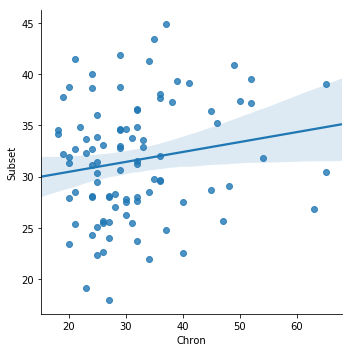

In [170]:
sns.lmplot(x='Chron', y='Subset', data=lm_df)
plt.show()

In [53]:
pm_results = {}

for age_diff in tqdm(range(40)):
    test_ages = list(sample_ages)
    test_ages[0] = test_ages[0] -20 + age_diff
    test_em = MethylationEM(methylation_table=meth_df.loc[age_sites].values,
                        sample_list=list(meth_df),
                        site_list=list(meth_df.index),
                        times=test_ages,
                        iter_limit=10,
                        err_tolerance=0.00001)
    pm_results[str(test_ages[0])] = test_em.UPM_EC_EM_results['PM_times']

100%|██████████| 40/40 [01:31<00:00,  2.36s/it]


In [54]:
initial = []
pm = []

for initial_guess, pm_ages in pm_results.items():
    initial.append(float(initial_guess))
    pm.append(pm_ages[0])

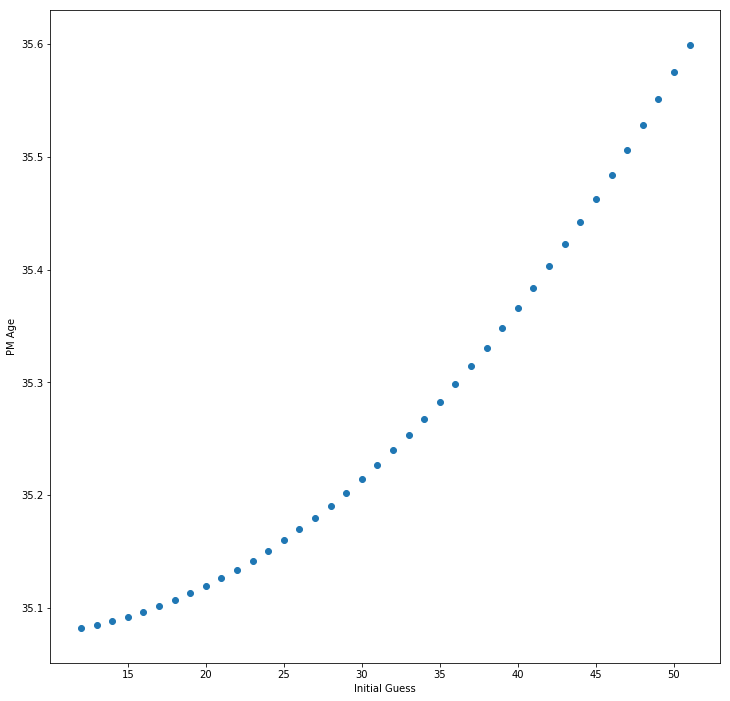

In [60]:
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(initial, pm)
plt.xlabel('Initial Guess')
plt.ylabel('PM Age')
plt.show()

In [61]:
pm_results = {}

for age_diff in tqdm(range(40)):
    test_ages = list(sample_ages)
    for i in range(len(test_ages)):
        test_ages[i] = test_ages[i] -20 + age_diff
    test_em = MethylationEM(methylation_table=meth_df.loc[age_sites].values,
                        sample_list=list(meth_df),
                        site_list=list(meth_df.index),
                        times=test_ages,
                        iter_limit=10,
                        err_tolerance=0.00001)
    pm_results[str(test_ages[0])] = test_em.UPM_EC_EM_results['PM_times']

100%|██████████| 40/40 [01:28<00:00,  2.21s/it]


In [68]:
initial = []
pm = []

for initial_guess, pm_ages in pm_results.items():
    initial.append(float(initial_guess))
    pm.append(pm_ages[0] - pm_ages[1])

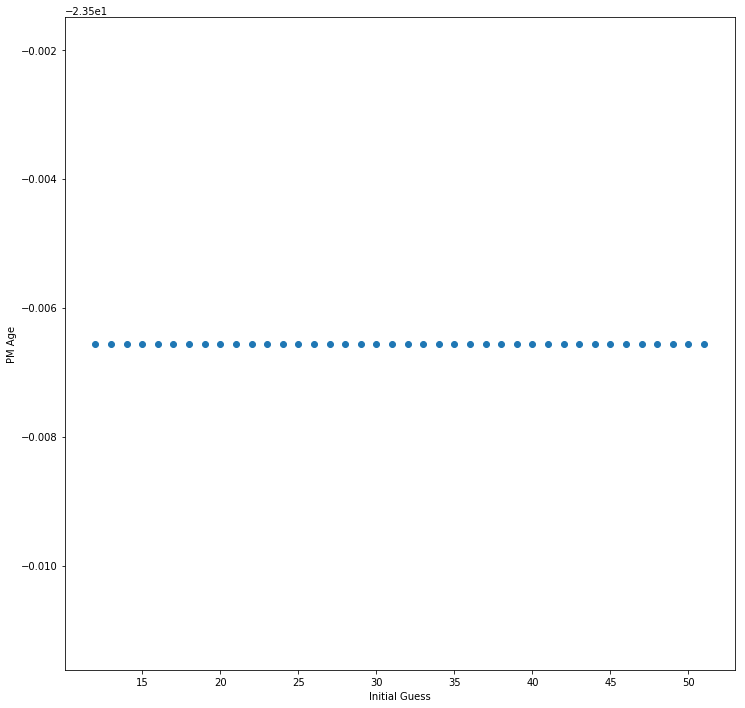

In [67]:
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(initial, pm)
plt.xlabel('Initial Guess')
plt.ylabel('PM Age')
plt.show()

In [ ]:
# fit polynomial model
test = np.polyfit(sample_ages, test_em.UPM_EC_EM_results['PM_times'], deg=1)

In [ ]:
test

In [ ]:
age_range = [x + 20 for x in range(50)]

In [ ]:
model_epigenetic_age = []

for age in age_range:
    model_epigenetic_age.append(sum([age*test[x]**x for x in range(len(test))]))

In [ ]:
example_matrix.phenotype_matrix.keys()

In [ ]:
age_dataframe = pd.DataFrame(data=[sample_ages, test_em.UPM_EC_EM_results['PM_times'], example_matrix.phenotype_matrix['diseasestatus (1=control, 2=scz patient)']]).T
age_dataframe.columns = ['Chronological Age', 'UPM Age', 'SCZ Status']

In [ ]:
age_dataframe['Absolute Difference'] = age_dataframe['Chronological Age'] - age_dataframe['UPM Age']

In [ ]:
age_dataframe['SCZ Status'].replace('2', 'SCZ', inplace=True)

In [ ]:
age_dataframe['SCZ Status'].replace('1', 'Control', inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='Chronological Age', y='UPM Age',hue='SCZ Status', data=age_dataframe, ax=ax)
ax.plot([np.asarray(sample_ages).min(), np.asarray(sample_ages).max()], [np.asarray(sample_ages).min(), np.asarray(sample_ages).max()], 'k--', lw=2)
plt.savefig('scz_control_epigentic_age.png', dpi=300)
plt.show()

In [ ]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(sample_ages, test_em.UPM_EC_EM_results['PM_times'], edgecolors=(0, 0, 0), color=sns.color_palette("Blues")[-2])
plot_fit = r2(sample_ages, test_em.UPM_EC_EM_results['PM_times'])
plot_fit = 'R**2 = ' + str(round(plot_fit,4))
ax.plot([np.asarray(sample_ages).min(), np.asarray(sample_ages).max()], [np.asarray(sample_ages).min(), np.asarray(sample_ages).max()], 'k--', lw=2)
ax.set_xlabel('Chronological Age', fontsize=14)
ax.set_ylabel('UPM Age', fontsize=14)
plt.show()

## Trait Age Prediction Correlation

In [ ]:
age_dataframe

In [ ]:
correlation_df = age_dataframe[['Chronological Age', 'UPM Age', 'Absolute Difference', 'SCZ Status']]

In [ ]:
import scipy.stats as stats

In [ ]:
stats.spearmanr(correlation_df['Absolute Difference'], correlation_df['SCZ Status'])

In [ ]:
correlation_df['SCZ Status'].replace('SCZ', 1.0, inplace=True)
correlation_df['SCZ Status'].replace('Control', 0.0, inplace=True)

In [ ]:
correlation_df = correlation_df.astype(float)

In [ ]:
correlation_df = correlation_df.corr(method='pearson')

In [ ]:
correlation_df

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(correlation_df, linewidths=.5, ax=ax, robust=True, cmap="YlGnBu")
plt.savefig('epigenticage_szc_status_correlation.png', dpi=300)
plt.show()


In [ ]:
additional_phenotype_data = '/Users/colinfarrell/Downloads/GSE74193_series_matrix.txt'

In [ ]:
new_matrix = SeriesMatrixParser(f'{additional_phenotype_data}')
new_matrix.run(description_ids=['!Series_title', '!Series_geo_accession',
                                    '!Series_pubmed_id', '!Series_summary',
                                    '!Series_overall_design',
                                    '!Series_sample_id', '!Series_relation'],
               sample_id='!Sample_title',
               phenotype_ids=['!Sample_characteristics_ch1'],
               matrix_start='!series_matrix_table_begin')

In [ ]:
control_status = [x.split('_')[1].replace('"', '') for x in new_matrix.sample_ids]

In [ ]:
upm_age_info = '/Users/colinfarrell/Downloads/upm_age.csv'

In [ ]:
age_dict = {}

for count, line in enumerate(open(upm_age_info, 'r')):
    if count > 0:
        line_split = line.replace('\n', '').split(',')
        age_dict[line_split[0]] = [float(line_split[1]), float(line_split[2])]

In [ ]:
sorted_ages_chron = []
sorted_ages_upm = []
for sample in new_matrix.matrix[0][1:]:
    sample_name = sample.replace('"', '')
    ages = age_dict[sample_name]
    sorted_ages_chron.append(ages[0])
    sorted_ages_upm.append(ages[1])

In [ ]:
brain_scz = [control_status, sorted_ages_chron, sorted_ages_upm]

In [ ]:
brain_df = pd.DataFrame(data=brain_scz).T

In [ ]:
brain_df.columns = ['Disease Status', 'Chron Age', 'UPM Age']

In [ ]:
brain_df['Disease Status'].replace('Control', 0, inplace=True)
brain_df['Disease Status'].replace('Schizo', 1, inplace=True)

In [ ]:
brain_df['Difference'] = brain_df['Chron Age'] - brain_df['UPM Age']

In [ ]:
brain_df = brain_df[brain_df['Chron Age'] >= 20.0]

In [ ]:
brain_df = brain_df.astype(float)

In [ ]:
brain_df.shape

In [ ]:
from scipy import optimize

In [ ]:
def func(x, a, b, c):
    return a * np.log(x) + c

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
UPM_age = brain_df['UPM Age'].values
chron_age = brain_df['Chron Age'].values
popt, pcov = optimize.curve_fit(func, chron_age[100:], UPM_age[100:])
plt.plot(sorted(chron_age), func(sorted(chron_age), *popt), 'r--', label="Fitted Curve")
sns.scatterplot(x='Chron Age', y='UPM Age', ax=ax, data=brain_df, hue='Disease Status')
ax.set_xlabel('Chronological Age', fontsize=18)
ax.set_ylabel('UPM Age', fontsize=18)
plt.gca().set_ylim(bottom=-40)
ax.text(0.02,.95,"y = %.4f ln(x) + (%.4f)"%(popt[0],popt[2]), transform=ax.transAxes)
plt.title('Schizophrenia Epigentic Age', fontsize=20)
plt.legend(loc=4)
#plt.savefig(f'{key}_age_upm_age.png', dpi=300)
plt.show()

In [ ]:
def get_expected_age(x, model_params):
    age = model_params[0] * np.log(x) + model_params[2]
    if np.isnan(age):
        age = 0
    return age

In [ ]:
brain_df['Expected Epigentic Age'] = [get_expected_age(x, popt) for x in brain_df['Chron Age']]

In [ ]:
brain_df['Expected Difference'] =  brain_df['Expected Epigentic Age'] - brain_df['UPM Age']

In [ ]:
brain_corr = brain_df.corr(method='pearson')

In [ ]:
stats.pearsonr(brain_df['Expected Difference'], brain_df['Disease Status'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(brain_corr, linewidths=.5, ax=ax, robust=True, cmap="YlGnBu")
#plt.savefig('epigenticage_szc_status_correlation.png', dpi=300)
plt.show()

### Lupus

In [ ]:
hiv_file = '/Users/colinfarrell/Downloads/GSE77696_series_matrix.txt'
hiv_beta_file = '/Users/colinfarrell/Downloads/GSE77696_MatrixProcessed.txt'

In [ ]:
hiv_matrix = SeriesMatrixParser(f'{hiv_file}')
hiv_matrix.run(description_ids=['!Series_title', '!Series_geo_accession',
                                    '!Series_pubmed_id', '!Series_summary',
                                    '!Series_overall_design',
                                    '!Series_sample_id', '!Series_relation'],
               sample_id='!Series_sample_id',
               phenotype_ids=['!Sample_characteristics_ch1'],
               matrix_start='!series_matrix_table_begin')

In [ ]:
hiv_age = [float(x) for x in hiv_matrix.phenotype_matrix['agebl']]

In [ ]:
hiv_samples = []

for count, line in enumerate(open(hiv_beta_file, 'r')):
    if count > 2:
        break
    elif count == 1:
        hiv_samples.append(line.replace('\n', '').split('\t'))

In [ ]:
hiv_samples_indicies = []
for count, sample in enumerate(hiv_samples[0]):
    if sample != 'Detection Pval':
        hiv_samples_indicies.append(count)

In [ ]:
hiv_sites_to_fit = ['cg16867657', 'cg06639320', 'cg22454769', 'cg21572722', 'cg14361627', 'cg24724428', 'cg07955995', 'cg08160331', 'cg08097417', 'cg23606718', 'cg07553761', 'cg25410668', 'cg24079702', 'cg03259243', 'cg04875128', 'cg10501210', 'cg22285878', 'cg20273670', 'cg00292135', 'cg02650266', 'cg18473521', 'cg09499629', 'cg25478614', 'cg11176990', 'cg19283806', 'cg06737494', 'cg02018902', 'cg19711579', 'cg15618978', 'cg11071401', 'cg14692377', 'cg07547549', 'cg16419235', 'cg07920503', 'cg21159778', 'cg00481951', 'cg23500537', 'cg21296230', 'cg23950157', 'cg17110586', 'cg22736354', 'cg05093315', 'cg18215449', 'cg20809087', 'cg07082267', 'cg01763090', 'cg12317815', 'cg11807280', 'cg09636661', 'cg11649376', 'cg06784991', 'cg21801378', 'cg01974375', 'cg03032497', 'cg02228185', 'cg11220950', 'cg08468401', 'cg00329615', 'cg18898125', 'cg19722847', 'cg05725703', 'cg08262002', 'cg04581938', 'cg23836737', 'cg25078444', 'cg17243289', 'cg06819923', 'cg22353329', 'cg18933331', 'cg19761273', 'cg14556683', 'cg08128734', 'cg01486610', 'cg22158769', 'cg15243034', 'cg03831054', 'cg20426994', 'cg20359994', 'cg06493994', 'cg21524899', 'cg25256723', 'cg17436656', 'cg02315732', 'cg16477091', 'cg25778262', 'cg26161329', 'cg01620164', 'cg19272468', 'cg00059225', 'cg06874016', 'cg03735592', 'cg13378934', 'cg02395812', 'cg14566959', 'cg12934382', 'cg09401099', 'cg05991454', 'cg17471102', 'cg02336143', 'cg01606885', 'cg25236230', 'cg11741201', 'cg16888547', 'cg08234504', 'cg17621438', 'cg22796704', 'cg02046143', 'cg09761247', 'cg16054275', 'cg26685941', 'cg21469505', 'cg01797043', 'cg03767531', 'cg03473532', 'cg03431918', 'cg22087053', 'cg11084334', 'cg04400972', 'cg01844642', 'cg04295144', 'cg13640414', 'cg14314729', 'cg10804656', 'cg23934731', 'cg00094518', 'cg08877357', 'cg11425788', 'cg05061804', 'cg26290632', 'cg02795076', 'cg07931844', 'cg05213896', 'cg04528819', 'cg03607117', 'cg06782035', 'cg25533247', 'cg23078123', 'cg07080372', 'cg24466241', 'cg24436906', 'cg07850154', 'cg26894354', 'cg02867102', 'cg13959344', 'cg17721618', 'cg23026864', 'cg10806820', 'cg14328457', 'cg25428494', 'cg12765028', 'cg11826475', 'cg04894619', 'cg18826637', 'cg11970349', 'cg09884851', 'cg22809047', 'cg04436528', 'cg01542719', 'cg14829814', 'cg23445461', 'cg14255824', 'cg06335143', 'cg06155229', 'cg22016779', 'cg23571812', 'cg26614073', 'cg02097792', 'cg15361590', 'cg04503319', 'cg09676860', 'cg25316339', 'cg13033938', 'cg15480367', 'cg22943590', 'cg02997982', 'cg08453194', 'cg18618815', 'cg00891995', 'cg16015712', 'cg16932827', 'cg19344626', 'cg15341124', 'cg10616795', 'cg23186333', 'cg08550421', 'cg05404236', 'cg08280341', 'cg11291003', 'cg12483947', 'cg11705975', 'cg01528542', 'cg25334393', 'cg25427880', 'cg17885226', 'cg16193278', 'cg20543183', 'cg13848598', 'cg20119148', 'cg03746976', 'cg05724065', 'cg21567504', 'cg02170478', 'cg14176752', 'cg10149533', 'cg16361302', 'cg13856810', 'cg18236477', 'cg15448975', 'cg20222376', 'cg20437276', 'cg16762684', 'cg07806886', 'cg00748589', 'cg19401340', 'cg18651026', 'cg14209784', 'cg00755588', 'cg03545227', 'cg19663246', 'cg24690071', 'cg16969368', 'cg26099158', 'cg21984532', 'cg04976697', 'cg10277912', 'cg04976151', 'cg07388493', 'cg07330212', 'cg18815943', 'cg10137837', 'cg23984434', 'cg13649056', 'cg11847992', 'cg00250761', 'cg15704699', 'cg17694795', 'cg12451153', 'cg19406003', 'cg01820962', 'cg26935102', 'cg04908625', 'cg25994988', 'cg11019211', 'cg23746497', 'cg19505546', 'cg00740914', 'cg04940570', 'cg24125828', 'cg05412028', 'cg18587063', 'cg17168836', 'cg01700003', 'cg13055199', 'cg02328239', 'cg09124496', 'cg04439252', 'cg19578183', 'cg13362112', 'cg13385220', 'cg17280346', 'cg24481841', 'cg27320127', 'cg24892069', 'cg07927379', 'cg16038120', 'cg24711336', 'cg00039326', 'cg19784428', 'cg16717122', 'cg00439658', 'cg08231709', 'cg04200607', 'cg08053686', 'cg00753885', 'cg27068143', 'cg17785250', 'cg22950493', 'cg07502389', 'cg07336350', 'cg17326555', 'cg19848940', 'cg17916490', 'cg00484358', 'cg10729426', 'cg05176991', 'cg12757011', 'cg10835286', 'cg20110742', 'cg14871932', 'cg18839637', 'cg18501647', 'cg15121420', 'cg06815715', 'cg03963327', 'cg00573770', 'cg24698655', 'cg16008966', 'cg03901431', 'cg10247798', 'cg04604946', 'cg04427498', 'cg18064714', 'cg10943458', 'cg14175438', 'cg06474661', 'cg19500607', 'cg19729744', 'cg15893346', 'cg01196788', 'cg00664406', 'cg08644498', 'cg17472736', 'cg24324483', 'cg15481583', 'cg04193160', 'cg18343474', 'cg15894389', 'cg01502244', 'cg17592231', 'cg10001186', 'cg06288154', 'cg04594378', 'cg03236802', 'cg08310088', 'cg11436113', 'cg12014646', 'cg03915012', 'cg04630292', 'cg06448705', 'cg04416734', 'cg20249566', 'cg10149054', 'cg19392831', 'cg16644497', 'cg19753867', 'cg16181396', 'cg26543112', 'cg13899108', 'cg05331060', 'cg26921969', 'cg05405914', 'cg21674927', 'cg02447229', 'cg18719170', 'cg22682811', 'cg05207048', 'cg07435445', 'cg15845821', 'cg08713098', 'cg08343101', 'cg20988565', 'cg08992872', 'cg15557036', 'cg13327545', 'cg00745389', 'cg22112841', 'cg13387994', 'cg05207637', 'cg18902090', 'cg14305711', 'cg17437939', 'cg20822990', 'cg23534245', 'cg20591472', 'cg27346545', 'cg07851675', 'cg25818109', 'cg15804973', 'cg02983424', 'cg16526416', 'cg02513379', 'cg18738190', 'cg08928145', 'cg08386692', 'cg18418479', 'cg09642020', 'cg19518666', 'cg20747538', 'cg08622677', 'cg01124546', 'cg01127300', 'cg21373192', 'cg07539798', 'cg16435923', 'cg20818778', 'cg20133890', 'cg20595453', 'cg10861731', 'cg18150280', 'cg01719405', 'cg09748749', 'cg20964856', 'cg23091758', 'cg22379463', 'cg19464804', 'cg12222588', 'cg23008153', 'cg18705909', 'cg08885800', 'cg27386529', 'cg17321954', 'cg12446246', 'cg04999352', 'cg13767625', 'cg12920180', 'cg12533658', 'cg08138505', 'cg00876267', 'cg14097619', 'cg25838150', 'cg01102833', 'cg08291506', 'cg21899500', 'cg11310639', 'cg21200408', 'cg05700079', 'cg11870100', 'cg16810343', 'cg04229059', 'cg13381486', 'cg24497732', 'cg08761208', 'cg07552803', 'cg27219955', 'cg27480727', 'cg24350475', 'cg02063488', 'cg08540945', 'cg03758021', 'cg00714309', 'cg20052760', 'cg04208403', 'cg02301740', 'cg01447660', 'cg07499673', 'cg23341182', 'cg16290275', 'cg02699218', 'cg15957394', 'cg03350900', 'cg14188401', 'cg16717713', 'cg07125666', 'cg22108374', 'cg25657261', 'cg04522691', 'cg09809672', 'cg03646916', 'cg04265051', 'cg05845217', 'cg23605843', 'cg11836829', 'cg13501527', 'cg08169949', 'cg12206199', 'cg18297751', 'cg11988910', 'cg26166595', 'cg04666029', 'cg02471940', 'cg22052948', 'cg02022733', 'cg09308553', 'cg06685111', 'cg12711760', 'cg27409484', 'cg03126058', 'cg23112821', 'cg04357717', 'cg04662594', 'cg18070593', 'cg22282410', 'cg00008033', 'cg26158023', 'cg14837598', 'cg00757070', 'cg27314569', 'cg17380661', 'cg02383785', 'cg10107473', 'cg07544187', 'cg22361181', 'cg08491188', 'cg13029847', 'cg16882373', 'cg17183905', 'cg22929506', 'cg01287975', 'cg08616061', 'cg07101980', 'cg12233363', 'cg20188739', 'cg12422450', 'cg00927554', 'cg01493685', 'cg05157098', 'cg12878812', 'cg26888530', 'cg12623930', 'cg17526301', 'cg17454234', 'cg16686396', 'cg09381003', 'cg04873577', 'cg04354805', 'cg10052840', 'cg27401724', 'cg27076669', 'cg10546626', 'cg22856324', 'cg01491071', 'cg21874213', 'cg00751156', 'cg21383487', 'cg20067719', 'cg06641388', 'cg01201215', 'cg03485669', 'cg17688525', 'cg03495011', 'cg08231710', 'cg05081953', 'cg09231862', 'cg01557798', 'cg07475957', 'cg08719712', 'cg06240854', 'cg10411339', 'cg10906284', 'cg15205547', 'cg02344113', 'cg18184411', 'cg25140188', 'cg01420159', 'cg21563471', 'cg08220136', 'cg08455099', 'cg00741333', 'cg23431721', 'cg21117668', 'cg03277049', 'cg11503396', 'cg00034076', 'cg26937798', 'cg05487664', 'cg10323433', 'cg09360770', 'cg05516295', 'cg00695112', 'cg19593767', 'cg19577206', 'cg17328514', 'cg02423574', 'cg13203811', 'cg19453093', 'cg03443986', 'cg06419432', 'cg27209729', 'cg26969888', 'cg17593342', 'cg05463027', 'cg24452821', 'cg20130213', 'cg07924380', 'cg25126698', 'cg19386336', 'cg12597389', 'cg11331344', 'cg19560758', 'cg01957732', 'cg16236766', 'cg08957484', 'cg01097725', 'cg18267374', 'cg24217948', 'cg15728256', 'cg01348004', 'cg23527621', 'cg09510752', 'cg23395688', 'cg04453050', 'cg09692396', 'cg04474832', 'cg02705918', 'cg21684012', 'cg07996838', 'cg00065935', 'cg01538344', 'cg10577534', 'cg11748880', 'cg08541518', 'cg23174607', 'cg02085953', 'cg18667659', 'cg14757228', 'cg16110788', 'cg23124451', 'cg22910295', 'cg05045027', 'cg14352983', 'cg02124499', 'cg01153166', 'cg19251242', 'cg24868150', 'cg23973429', 'cg15640503', 'cg06757405', 'cg09099868', 'cg07583137', 'cg21186299', 'ch.2.42601115R', 'cg19908207', 'cg13657200', 'cg11523290', 'cg00448560', 'cg16737749', 'cg19141644', 'cg13850871', 'cg13942826', 'cg03132729', 'cg06661266', 'cg06492796', 'cg22897615', 'cg06711175', 'cg04035392', 'cg01289541', 'cg07368443', 'cg06712204', 'cg21174055', 'cg07979752', 'cg04084157', 'cg20813374', 'cg16454902', 'cg08445802', 'cg20992114', 'cg21928406', 'cg23016129', 'cg24543696', 'cg00193668', 'cg04881228', 'cg20176648', 'cg12363903', 'cg21139312', 'cg27653384', 'cg22747507', 'cg16003790', 'cg14620572', 'cg05308819', 'cg08578520', 'cg01243823', 'cg11139646', 'cg13851368', 'cg24853724', 'cg20692569', 'cg26191447', 'cg16785344', 'cg07797372', 'cg00001583', 'cg19056004', 'cg01087775', 'cg19811148', 'cg05308645', 'cg25371036', 'cg24922090', 'cg12570134', 'cg04861640', 'ch.14.97331099F', 'cg24430580', 'cg04078410', 'cg01649334', 'cg06458239', 'cg12145907', 'cg10751726', 'cg00590036', 'cg02148324', 'cg10668933', 'cg15059608', 'cg13473356', 'cg14134497', 'cg22719623', 'cg00101260', 'cg06911110', 'cg19029181', 'cg13823169', 'cg16583552', 'cg01139586', 'cg03331263', 'cg20445053', 'cg06084210', 'cg13221458', 'cg04738109', 'cg18882457', 'cg19093820', 'cg21084284', 'cg25826226', 'cg27067781', 'cg09308842', 'cg26153045', 'cg23049291', 'cg10242160', 'cg15305732', 'cg04036898', 'cg21709871', 'cg15626285', 'cg01791648', 'cg18079948', 'cg01302656', 'cg12412079', 'cg14142007', 'cg11076306', 'cg16718162', 'cg18088844', 'cg19060970', 'cg07388347', 'cg03102824', 'cg25413977', 'cg12706938', 'cg07208703', 'cg14556303', 'ch.10.2676717R', 'cg24463634', 'cg14257429', 'cg09120938', 'cg16228359', 'cg11067907', 'cg00327072', 'cg06739520', 'cg01747664', 'cg04193015', 'cg00808170', 'cg08297751', 'cg03399905', 'ch.2.207814544R', 'cg22273555', 'cg13929658', 'cg18751682', 'cg17729667', 'cg03337035', 'cg08079908', 'cg27430977', 'cg04961582', 'cg12648074', 'cg01856162', 'cg05666820', 'cg03738025', 'cg11143148', 'cg12033216', 'cg24232083', 'cg04731544', 'cg26156448', 'cg21523251', 'cg18497052', 'cg25998745', 'cg02773433', 'cg06943835', 'cg08727303', 'cg21751873', 'cg02820759', 'cg11573518', 'cg16219603', 'cg17200920', 'cg15712510', 'cg16911349', 'cg26158959', 'cg06893273', 'cg21940640', 'cg00116092', 'cg12776156', 'cg18318878', 'cg20219381', 'cg14674720', 'cg14731462', 'cg19855470', 'cg23744638', 'cg12739664', 'cg12530503', 'cg10376827', 'cg21239940', 'cg05798429', 'cg01314044', 'cg08461949', 'cg17783401', 'cg04021562', 'cg22402467', 'cg11320449', 'cg24433287', 'cg17626960', 'cg07326413', 'cg08558886', 'cg21188820', 'cg21567958', 'cg11204212', 'cg26477573', 'cg25352836', 'cg06991484', 'cg08102508', 'cg17066943', 'cg16431787', 'cg15169121', 'cg12258344', 'cg27252696', 'cg05656900', 'cg06279276', 'cg13234110', 'cg18587806', 'cg21186955', 'cg22777186', 'cg24369989', 'cg09188763', 'cg00099976', 'cg00451635', 'cg08808402', 'cg15457058', 'cg20294304', 'cg21493505', 'cg25049597', 'cg07721203', 'cg14977938', 'cg00989492', 'cg14442492', 'cg02872426', 'cg27205687', 'cg13120986', 'cg22162281', 'cg06931612', 'cg15538427', 'cg03211864', 'cg02004723', 'cg05121480', 'cg16529477', 'cg23368715', 'cg20102280', 'cg12534424', 'cg20556951', 'cg05085585', 'cg19077806', 'cg14195318', 'cg06638433', 'cg00048759', 'cg00636737', 'cg25693132', 'cg19936954', 'cg06821199', 'cg04845915', 'cg04955914', 'cg12278474', 'cg17784808', 'cg18862005', 'cg16541931', 'cg04762312', 'cg20324858', 'cg19287501', 'cg00103778', 'cg07715777', 'cg00394316', 'cg12172057', 'cg10123654', 'cg05619598', 'cg05316627', 'cg10476085', 'cg19065831', 'cg26709950', 'cg08810238', 'cg21800232', 'cg09906752', 'cg00335744', 'cg12833465', 'cg05557932', 'cg18568843', 'cg14176088', 'cg00176863', 'cg20816447', 'cg00486340', 'cg07038342', 'cg25861699', 'cg16061228', 'cg07746882', 'cg06352730', 'cg27641522', 'cg02402091', 'cg10805721', 'cg18313790', 'cg06570224', 'cg27658304', 'cg27035734', 'cg23119026', 'cg04753583', 'cg22705959', 'cg20669012', 'cg06933824', 'cg24807850', 'cg10604476', 'cg09706243', 'cg20629183', 'cg07521929', 'cg23847109', 'cg24168221', 'cg17389813', 'cg01077178', 'cg00199059', 'cg18395623', 'cg22851420', 'cg05655457', 'cg08473330', 'cg20252022', 'cg13393785', 'cg14507845', 'cg22517995', 'cg00095259', 'cg08468082', 'cg06707978', 'cg15934958', 'cg23187308', 'cg02391713', 'cg20049415', 'cg01222316', 'cg05009601', 'cg25756780', 'cg27345757', 'cg26886965', 'cg07639720', 'cg03184588', 'cg17508941', 'cg11051055', 'cg15379412', 'cg03237606', 'cg03752138', 'cg13786089', 'cg12079303', 'cg04544699', 'cg14149172', 'cg14522815', 'cg08988797', 'cg22176895', 'cg26293546', 'cg05346491', 'cg03149128', 'cg03422911', 'cg24719321', 'cg19414591', 'cg20442599', 'cg13868393', 'cg06526721', 'cg03474926', 'cg27304406', 'cg17832704', 'cg09001514', 'cg07869256', 'cg25047092', 'cg05204798', 'cg05923226', 'cg02457328', 'cg17326173', 'cg22927302', 'cg25109663', 'cg15829826', 'cg12848065', 'cg14983586', 'cg02024925', 'cg24020215', 'cg23052220', 'cg21502255', 'cg12277666', 'cg18034299', 'cg19926902', 'cg06899799', 'cg05003422', 'cg25031476', 'cg08570034', 'cg10658666', 'cg25425705', 'cg08854987', 'cg00792107', 'cg22820188', 'cg16243652', 'cg25645064', 'cg13324103', 'cg03208198', 'cg02222791', 'cg00168942', 'cg21036336', 'cg10143811', 'cg22934295', 'cg12597839', 'cg19809499', 'cg05106770', 'cg03585912', 'cg15550618', 'cg25863147', 'cg03359540', 'cg21449170', 'cg20168514', 'cg22358580', 'cg16547027', 'cg01256539', 'cg03484180', 'cg05898524', 'cg15277914', 'cg22960971', 'cg16705627']

In [ ]:
hiv_fit_matrix = []

for count, line in enumerate(open(hiv_beta_file, 'r')):
    if count > 0:
        line_split = line.replace('\n', '').split('\t')
        beta_values_line = [line_split[x] for x in hiv_samples_indicies]
        beta_values = convert_string_betas(beta_values_line[1:])
        if beta_values_line[0] in hiv_sites_to_fit:
            hiv_fit_matrix.append(beta_values)

In [ ]:
len(hiv_fit_matrix[0])

In [ ]:
hiv_em = MethylationEM(methylation_table=hiv_fit_matrix,
                        sample_list=hiv_samples,
                        site_list=hiv_sites_to_fit,
                        times=hiv_age,
                        iter_limit=10,
                        err_tolerance=0.00001)

In [ ]:
hiv_matrix.phenotype_matrix.keys()

In [ ]:
hiv_df = pd.DataFrame(data=[hiv_matrix.phenotype_matrix['agebl'], hiv_em.UPM_EC_EM_results['PM_times'], hiv_matrix.phenotype_matrix['hiv']]).T


In [ ]:
hiv_df.columns = ['Chron Age', 'UPM Age', 'Disease Status']

In [ ]:
hiv_df = hiv_df.astype(float)

In [ ]:
hiv_df['Age Difference'] = hiv_df['Chron Age'] - hiv_df['UPM Age']

In [ ]:
hiv_corr = hiv_df.corr(method='spearman')

In [ ]:
stats.spearmanr(hiv_df['Expected UPM Age - UPM Age'], hiv_df['Disease Status'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(hiv_corr[['Expected UPM Age - UPM Age','Disease Status']].loc[['Expected UPM Age - UPM Age','Disease Status']] , linewidths=.5, ax=ax, robust=True, cmap="YlGnBu")
#plt.savefig('epigenticage_hiv_status_correlation.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='Chron Age', y='UPM Age',hue='Disease Status', data=hiv_df, ax=ax)
ax.plot([np.asarray(hiv_age).min(), np.asarray(hiv_age).max()], [np.asarray(hiv_age).min(), np.asarray(hiv_age).max()], 'k--', lw=2)
#plt.savefig('scz_control_epigentic_age.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
UPM_age = hiv_df['UPM Age'].values
chron_age = hiv_df['Chron Age'].values
popt, pcov = optimize.curve_fit(func, chron_age, UPM_age)
plt.plot(sorted(chron_age), func(sorted(chron_age), *popt), 'r--', label="Trend")
sns.scatterplot(x='Chron Age', y='UPM Age', ax=ax, data=hiv_df, hue='Disease Status', s=100)
ax.set_xlabel('Chronological Age', fontsize=18)
ax.set_ylabel('UPM Age', fontsize=18)
plt.gca().set_ylim(bottom=0)
ax.text(0.02,.95,"y = %.4f ln(x) + (%.4f)"%(popt[0],popt[2]), transform=ax.transAxes)
plt.title('HIV Epigentic Age', fontsize=20)
plt.legend(loc=4)
plt.savefig(f'hiv_age_upm_age.png', dpi=300)
plt.show()

In [ ]:
stats.spearmanr(hiv_df['Expected UPM Age - UPM Age'], hiv_df['Disease Status'])

In [ ]:
hiv_df['Expected UPM Age'] = [get_expected_age(x, popt) for x in hiv_df['Chron Age']]

In [ ]:
hiv_df['Expected UPM Age - UPM Age'] = hiv_df['Expected UPM Age'] - hiv_df['UPM Age']

In [70]:
import seaborn as sns

In [71]:
iris = sns.load_dataset("iris")

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)>

In [ ]:
iris